In [ ]:
# default_exp cells
%load_ext autoreload
%autoreload 2

# Cells
> Combine exposure, and list of weighted photons to create cells for likelihood calculation

A list of cells, represented with a DataFrame, has the following columns

- t, tw : time (in MJD) an width of the cell
- e : the exposure, relative to the expection for the cell size
- n : the number of photons
- w : a list of weights, represtend by unit8 numbers: divide by 256 for the values
- S,B : expected values for the sums of w and (1-w) for the cell

Implemented here:

- `get_cells` -- return such a set for a given source.
- `partition_cells` -- combine a set of cells with a partition, as in the Bayesian Block analysis

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#export
import os
import numpy as np
import pandas as pd
from light_curves.config import Config,  PointSource
from light_curves.photon_data import get_photon_data
from light_curves.weights import add_weights, check_source
from light_curves.exposure import get_exposure

Prepare test data 

In [ ]:

config = Config()
source = PointSource('Geminga')

if config.valid:
    print(f'Loading photon data for using source {source.name} to test adding weights')
    check_source(config.files, source)
    photon_data = get_photon_data(config, source )
    add_weights(config, config.files, photon_data, source)
    exposure = get_exposure(config,  source)
else:
    print('Not testing since no files.')

Loading photon data for using source Geminga to test adding weights
restored photons_Geminga from cache

	Selected 1313726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
using cache with key "exposure_Geminga", exists: False
Processing 12 S/C history (FT2) files
  applying cuts cos(theta) < 0.4,  z < 100
	file /home/burnett/work/lat-data/ft2/ft2_2008.fits: 362996 entries, 360944 in GTI
	file /home/burnett/work/lat-data/ft2/ft2_2009.fits: 874661 entries, 870446 in GTI
	file /home/burnett/work/lat-data/ft2/ft2_2010.fits: 889547 entries, 884697 in GTI
	file /home/burnett/work/lat-data/ft2/ft2_2011.fits: 882832 entries, 871672 in GTI
	file /home/burne

In [ ]:
#export
def _get_default_bins(config, exposure):
    """set up default bins from exposure; adjust stop to come out even
    # round to whole day
    """

    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])
    if config.mjd_range is None:
        config.mjd_range = (start,stop)

    step = config.time_interval
    nbins = int(round((stop-start)/step))
    tb =time_bins = np.linspace(start, stop, nbins+1)
    if config.verbose>0:
        print(f'Time bins: {nbins} intervals of {step} days, '\
              f'in range ({time_bins[0]:.1f}, {time_bins[-1]:.1f})')
    return time_bins

In [ ]:
if config.valid: time_bins = _get_default_bins(config, exposure)     
else: time_bins = None

Time bins: 4015 intervals of 1 days, in range (54683.0, 58698.0)


In [ ]:
#export
def _get_binned_exposure(time_bins, exposure):

    # get stuff from photon data, exposure calculation
    exp   = exposure.exposure.values
    estart= exposure.start.values
    estop = exposure.stop.values

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_bins)
    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]
    return np.diff(cum)/(cum[-1]-cum[0]) * (len(time_bins)-1)

Create the binned exposure, and make a histogram of its output, the exposure per bin
relative to the aveage. 

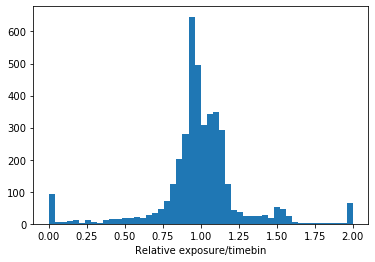

In [ ]:
if time_bins is not None:
    binned_exposure = _get_binned_exposure(time_bins, exposure)
    plt.hist(binned_exposure.clip(0,2), 50, histtype='stepfilled');
    plt.xlabel('Relative exposure/timebin');

In [ ]:
#export
class _WeightedCells(object):
    """ Generate a list of cells, with access to cell data
        weights
    """

    def __init__(self, config, source,
                 photon_data:'DataFrame with photon data',
                 exposure: 'DataFrame with exposure',
                 bins: 'time bins default if None'=None,
                ):
        """
        Use time binning photon_data to generate list of cells
        """
        self.source_name =source.name
        self.verbose = config.verbose

        bins = bins if bins is not None else  _get_default_bins(config, exposure)
        self.bins = bins 
        
        # restrict photons to range of bin times
        photons = photon_data.query(f'{bins[0]}<time<{bins[-1]}')
 
        self.N = len(bins)-1 # number of bins
        self.bin_centers = 0.5*(bins[1:]+bins[:-1])
        
        # exposure binned as well
        self.fexposure = _get_binned_exposure(bins, exposure)

        # get the photon data with good weights, not NaN
        w = photons.weight
        good = np.logical_not(np.isnan(w))
        self.photons = photons.loc[good]
        self.weights = w = self.photons.weight.values
        
        # estimates for averate signal and background per cell
        self.S = np.sum(w)/self.N
        self.B = np.sum(1-w)/self.N

        # use photon times to get indices of bin edges
        self._edges = np.searchsorted(self.photons.time, bins)


    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.fexposure)} intervals from {self.bins[0]:.1f} to {self.bins[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''

    def __getitem__(self, i):
        """ get info for ith time bin and return dict with
            t : MJD
            tw: bin width,
            e: exposure as fraction of total,
            n : number of photons in bin
            w : list of weights as uint8 integers<=255
            S,B:  value
        """
        k   = self._edges

        wts = np.array(self.weights[k[i]:k[i+1]]*256, np.uint8)
        n = len(wts)
        e = self.fexposure[i]
        tw  = self.bins[i+1]-self.bins[i]

        return dict(
                t=self.bin_centers[i], # time
                tw = tw,  # bin width
                e=e, # moving to this name
                n=n, # number of photons in bin
                w=wts,
                S= e *self.S,
                B= e *self.B,
                )

    def __len__(self):
        return self.N

    @property
    def dataframe(self):
        """ combine all cells into a dataframe
        """
        df = pd.DataFrame([cell for cell in self])
        return df


In [ ]:
#export
def get_cells(config,  source, bins=None):
    """Return a cells DataFrame for the source
    
    - source -- `PointSource` object
    - bins -- None, or an array of bin edges to define cells. If None use the default defined in config
    
  
    """

    photon_data = get_photon_data(config,   source )
    add_weights(config, config.files, photon_data, source)
    exposure = get_exposure(config,  source)

    return _WeightedCells(config, source,photon_data, exposure, bins).dataframe

In [ ]:
show_doc(get_cells)

<h4 id="get_cells" class="doc_header"><code>get_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>get_cells</code>(**`config`**, **`source`**, **`bins`**=*`None`*)

Return a cells DataFrame for the source

- source -- [`PointSource`](/light_curves/config.html#PointSource) object
- bins -- None, or an array of bin edges to define cells. If None use the default defined in config

Create a table of cells

In [ ]:
#hide
if config.valid:
    cells = get_cells(config, source)

restored photons_Geminga from cache

	Selected 1313726 photons within 5 deg of  (195.13,4.27)
	Energies: 100.0-1000000 MeV
	Dates:    2008-08-04 15:46 - 2019-08-03 01:17
	MJD  :    54682.7          - 58698.1         
Load weights from file /mnt/c/users/thbur/OneDrive/fermi/weight_files/Geminga_weights.pkl
	Found: PSR J0633+1746 at (195.14, 4.27)
	Applyng weights: 240 / 1313726 photon pixels are outside weight region
	233109 weights set to NaN
using cache with key "exposure_Geminga", exists: True
Time bins: 4015 intervals of 1 days, in range (54683.0, 58698.0)


A look at the contents of the first cell

In [ ]:
#hide
cells.iloc[0] if config.valid else None

t                                               54683.5
tw                                                    1
e                                               1.26456
n                                                   330
w     [244, 214, 174, 5, 246, 150, 187, 65, 91, 215,...
S                                               225.585
B                                               114.707
Name: 0, dtype: object

An important check of the procedure is a comparison of the sum of weights in a cell with the exposure for that time interval.

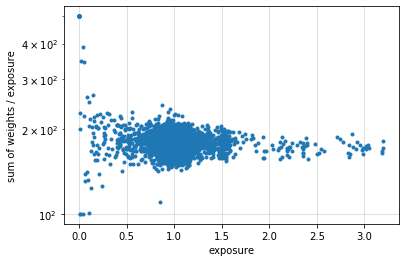

In [ ]:
#collapse_input
if config.valid:
    # check sums
    S = np.sum(cells.S.values)
    B = np.sum(cells.B.values)
    n = np.sum(cells.n)
    assert np.abs((S+B)/n -1)  < 0.1, f'Failed count check: total counts, {n}  shouuld be same as S+B,  {S+B}'
    wsum = cells.w.apply(np.sum)/256.;
    plt.semilogy(cells.e, (wsum/cells.e).clip(1e2,5e2), '.');
    plt.xlabel('exposure')
    plt.ylabel('sum of weights / exposure');
    plt.grid(alpha=0.5)

In [ ]:
#export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edges delimiting boundaries between cells
    """
    # should check limitsk
    ii = np.searchsorted(cells.t, edges)
    
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

        ca, cb = subset.iloc[0], subset.iloc[-1]
        newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )

        for col in 'tw e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)        
    

In [ ]:
#hide
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
- cells -- A DataFrame of cells
- edges  -- a list of edges delimiting boundaries between cells

In [ ]:
#hide
if config.valid:
    print('Test partition by selecting subset of current bin edges')
    edges = cells.t.values-cells.tw.values/2
    width = 4
    newbins = edges[:20:width ];
    pd.set_option('display.precision',2 )
    pd.set_option('display.max_seq_items',4 )
    newcells = partition_cells(config, cells, newbins)
    print(newcells)

Test partition by selecting subset of current bin edges
         t   tw     e     n       S       B                         w
0  54685.0  4.0  1.27  1394  904.65  460.01   [244, 214, 174, 5, ...]
1  54689.0  4.0  1.27  1380  906.13  460.75  [246, 185, 82, 163, ...]
2  54693.0  4.0  1.07  1202  766.07  389.54   [240, 33, 231, 22, ...]
3  54697.0  4.0  0.89   938  636.59  323.70  [150, 43, 185, 235, ...]


## Monte Carlo

Generate a set of cells

In [ ]:
from scipy.stats import poisson, uniform
r = poisson.rvs(mu=40, size=10000)
np.mean(r), np.std(r)**2


(40.0106, 39.871087640000006)

In [ ]:
#export
class SampleFunction():
    """ Sample an arbitrary function or histogram
    
    - func -- the function, or a histogram
    - a,b  -- limits
    - n    -- table size
    """
    from scipy.stats import uniform
    
    def __init__(self, func, a, b, n=100):
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2

        if not hasattr(func, '__len__'):
            # evaluate ad bin centers
            y = [func(t-dx) for t in self.x]
        else:
            n = len(func) 
            self.x = np.linspace(a,b,n)
            y = func
        cy = np.cumsum(y)
        self.sy = (cy-cy[0])/([cy[-1]-cy[0]])
        
    def __call__(self, r):
        """evaluate intergral. expect 0<r<1 """
        return np.interp(r, self.sy, self.x)
    
    def generate(self, size):
        """Generate `size` values
        """
        return self(uniform.rvs(size=size))

(-4.0, -6.661338147750939e-16, 4.0)

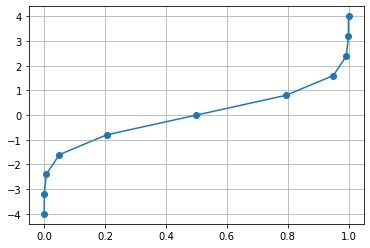

In [ ]:
n = 10
sf = SampleFunction(lambda x: np.exp(-(x**2)/2), -4, 4, n)

plt.plot(sf.sy, sf.x, '-o');
plt.grid()
sf(0), sf(0.5), sf(1)

In [ ]:
#hide    
data = sf.generate(10000)
tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

In [ ]:
#
w = photon_data.weight.values
gw = w[~np.isnan(w)]
h = np.histogram(gw, np.linspace(0,1,51))[0]; 
sf2 = SampleFunction(h, 0,1)

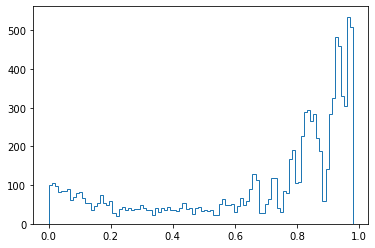

In [ ]:
data2 = sf2.generate(10000)
plt.hist(data2, bins=100);

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_load_gti.ipynb.
Converted 03_exposure.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 07_cells.ipynb.
Converted 08_simulation.ipynb.
Converted 09_poisson.ipynb.
Converted 10_loglike.ipynb.
Converted 11_lightcurve.ipynb.
Converted 12_roadmap.ipynb.
Converted 13_kerr_comparison.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Thu Dec 17 15:47:22 PST 2020
